# Step 1: Loading and Exploring the Dataset

In [1]:
import pandas as pd
import os.path as op
from zipfile import ZipFile
from urllib.request import urlretrieve
import matplotlib.pyplot as plt


# Download and extract the dataset
ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = "Downloads/ml-100k.zip"  # Store ZIP file in 'Files' folder
ML_100K_FOLDER = "Downloads/ml-100k"  # Extract inside 'Files' folder

if not op.exists(ML_100K_FILENAME):
    print(f'Downloading {ML_100K_URL} to {ML_100K_FILENAME}...')
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print(f'Extracting {ML_100K_FILENAME} to {ML_100K_FOLDER}...')
    ZipFile(ML_100K_FILENAME).extractall("Downloads/")

# Load ratings
raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])

# Load item metadata
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')

# Display first few rows
print("Ratings DataFrame:")
print(raw_ratings.head())
print("\nItems DataFrame:")
print(items.head())

Extracting Downloads/ml-100k.zip to Downloads/ml-100k...
Ratings DataFrame:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Items DataFrame:
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...  
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...  
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...  
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...  


# Step 2: Preprocessing the Data

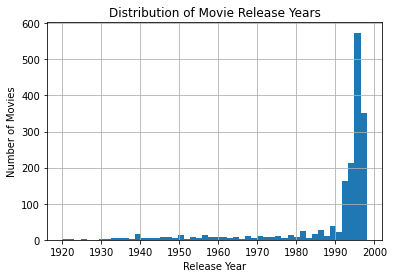

Merged DataFrame (first 5 rows):
   item_id             title release_date  video_release_date  \
0        1  Toy Story (1995)  01-Jan-1995                 NaN   
1        1  Toy Story (1995)  01-Jan-1995                 NaN   
2        1  Toy Story (1995)  01-Jan-1995                 NaN   
3        1  Toy Story (1995)  01-Jan-1995                 NaN   
4        1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  release_year  user_id  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      308   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      287   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      148   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      280   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995       66   

   rating  timestamp  
0       4  887736532  
1       5  875334088  
2       4  877019411  
3       4

In [2]:
from sklearn.model_selection import train_test_split

# Extract release year from release_date
def extract_year(release_date):
    if isinstance(release_date, str):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    return 1920  # Default for missing values

items['release_year'] = items['release_date'].map(extract_year)

# Visualize release year distribution
items.hist('release_year', bins=50)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.show()

# Merge ratings with items
all_ratings = pd.merge(items, raw_ratings, on='item_id')
print("Merged DataFrame (first 5 rows):")
print(all_ratings.head())

# Get max user and item IDs
max_user_id = all_ratings['user_id'].max()
max_item_id = all_ratings['item_id'].max()
print(f"Max user ID: {max_user_id}, Max item ID: {max_item_id}")

# Rating statistics
print("\nRating Statistics:")
print(all_ratings['rating'].describe())

# Calculate movie popularity
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items, on='item_id')
print("\nTop 10 Most Popular Movies:")
print(items.nlargest(10, 'popularity')[['title', 'popularity']])

# Enrich ratings with popularity
all_ratings = pd.merge(popularity, all_ratings, on='item_id')

# Split into train and test sets
ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0
)

# Extract features for training and testing
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']
user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# Step 3: Building a Simple Embedding Model

In [3]:
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model

# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embedding layers
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# Flatten embeddings
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Dot product
y = Dot(axes=1)([user_vecs, item_vecs])

# Build and compile model
model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

# Initial predictions
initial_train_preds = model.predict([user_id_train, item_id_train])
print("Shape of initial predictions:", initial_train_preds.shape)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Shape of initial predictions: (80000, 1)


# Step 4: Evaluating the Untrained Model

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute errors
squared_differences = np.square(initial_train_preds[:, 0] - rating_train.values)
absolute_differences = np.abs(initial_train_preds[:, 0] - rating_train.values)

print("Random init MSE: %.3f" % np.mean(squared_differences))
print("Random init MAE: %.3f" % np.mean(absolute_differences))

# Verify with scikit-learn
print("Random init MSE (sklearn): %.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE (sklearn): %.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MSE: 13.719
Random init MAE: 3.529
Random init MSE (sklearn): 13.719
Random init MAE (sklearn): 3.529


# Step 5: Training the Model

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 4s 59us/step - loss: 2.9272 - val_loss: 1.3495
Epoch 2/6
72000/72000 [==============================] - 4s 54us/step - loss: 0.9701 - val_loss: 0.8350
Epoch 3/6
72000/72000 [==============================] - 4s 55us/step - loss: 0.7813 - val_loss: 0.7831
Epoch 4/6
72000/72000 [==============================] - 4s 53us/step - loss: 0.7480 - val_loss: 0.7660
Epoch 5/6
72000/72000 [==============================] - 2s 31us/step - loss: 0.7339 - val_loss: 0.7571
Epoch 6/6
72000/72000 [==============================] - 2s 32us/step - loss: 0.7240 - val_loss: 0.7530


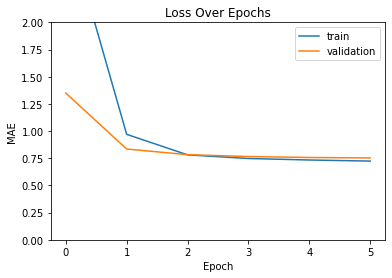

Final test MSE: 0.944
Final test MAE: 0.747
Final train MSE: 0.857
Final train MAE: 0.705


In [5]:
# Train the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=6, validation_split=0.1,
                    shuffle=True)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate on test set
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %.3f" % mean_absolute_error(test_preds, rating_test))

# Evaluate on training set
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %.3f" % mean_absolute_error(train_preds, rating_train))

# Step 6: Building a Deep Recommender Model

Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 6s 88us/step - loss: 1.0192 - val_loss: 0.7588
Epoch 2/5
64000/64000 [==============================] - 5s 77us/step - loss: 0.7529 - val_loss: 0.7488
Epoch 3/5
64000/64000 [==============================] - 5s 77us/step - loss: 0.7402 - val_loss: 0.7429
Epoch 4/5
64000/64000 [==============================] - 5s 78us/step - loss: 0.7315 - val_loss: 0.7399
Epoch 5/5
64000/64000 [==============================] - 6s 96us/step - loss: 0.7242 - val_loss: 0.7332


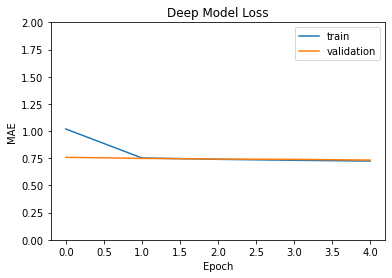

Deep model test MSE: 0.921
Deep model test MAE: 0.731


In [6]:
from keras.layers import Concatenate, Dense, Dropout

# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embeddings
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# Flatten
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Concatenate and add dense layers
input_vecs = Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(0.3)(input_vecs)  # Prevent overfitting
x = Dense(64, activation='relu')(input_vecs)
y = Dense(1, activation='linear')(x)

# Build and compile
model_deep = Model(inputs=[user_id_input, item_id_input], outputs=y)
model_deep.compile(optimizer='adam', loss='mae')

# Train
history_deep = model_deep.fit([user_id_train, item_id_train], rating_train,
                              batch_size=64, epochs=5, validation_split=0.2,
                              shuffle=True)

# Plot loss
plt.plot(history_deep.history['loss'], label='train')
plt.plot(history_deep.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Deep Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate
test_preds_deep = model_deep.predict([user_id_test, item_id_test])
print("Deep model test MSE: %.3f" % mean_squared_error(test_preds_deep, rating_test))
print("Deep model test MAE: %.3f" % mean_absolute_error(test_preds_deep, rating_test))

# Step 7: Retrieving and Visualizing Embeddings

Embedding for 'Toy Story (1995)' (item_id=1):
[-0.50753736  0.37955856  0.3995729  -0.29282433  0.17885558  0.35944963
 -0.05620178  0.3263117  -0.4526397   0.3959551   0.41165316 -0.4582024
  0.34513637  0.36026075 -0.3131637  -0.41931856 -0.3964191  -0.05493119
  0.34755656 -0.40136492  0.48041674  0.17234604 -0.3363692  -0.38675475
 -0.34582177 -0.43343788  0.32197043  0.5192161  -0.35172063  0.24899098]

Movies similar to 'Return of the Jedi':
Babe (1995): 0.369
GoldenEye (1995): 0.412
M*A*S*H (1970): 0.412
Contact (1997): 0.414
Wild Bunch, The (1969): 0.415
Legends of the Fall (1994): 0.420
Princess Bride, The (1987): 0.424
Dead Poets Society (1989): 0.440
Godfather: Part II, The (1974): 0.447
Patton (1970): 0.449


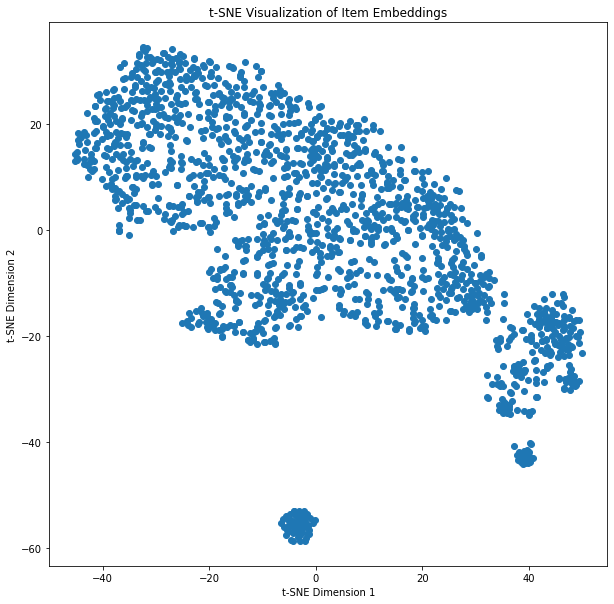

In [7]:
# Extract embeddings
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]

# Example embedding
print("Embedding for 'Toy Story (1995)' (item_id=1):")
print(item_embeddings[1])

# Cosine similarity function
def cosine(x, y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.dot(x, y)

# Euclidean distance function
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Find similar items
def most_similar(idx, top_n=10, mode='euclidean'):
    if mode == 'euclidean':
        dists = euclidean_distances(item_embeddings[idx])
    else:
        dists = -np.array([cosine(item_embeddings[idx], emb) for emb in item_embeddings])
    top_indices = np.argsort(dists)[1:top_n+1]  # Exclude self
    return [(items.iloc[i]['title'], dists[i]) for i in top_indices]

# Similar movies to 'Return of the Jedi' (item_id=181)
print("\nMovies similar to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="euclidean"):
    print(f"{title}: {dist:.3f}")

# Visualize with t-SNE
from sklearn.manifold import TSNE
item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1])
plt.title("t-SNE Visualization of Item Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 8: Making Recommendations

In [8]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id + 1)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = [i for i in item_ids if i not in seen_movies]

    print(f"User {user_id} has seen {len(seen_movies)} movies, including:")
    for title in all_ratings[seen_mask].nlargest(5, 'popularity')['title']:
        print(f"   {title}")
    print(f"Computing ratings for {len(item_ids)} other movies:")

    user_ids = np.full(len(item_ids), user_id)
    rating_preds = model_deep.predict([user_ids, np.array(item_ids)])

    item_preds = list(zip(item_ids, rating_preds[:, 0]))
    item_preds.sort(key=lambda x: x[1], reverse=True)
    rec_items = item_preds[:top_n]
    return [(items.iloc[i-1]['title'], pred) for i, pred in rec_items]  # Adjust for 0-based indexing

# Recommend for user 5
print("\nRecommendations for user 5:")
for title, pred_rating in recommend(5):
    print(f"    {pred_rating:.1f}: {title}")


Recommendations for user 5:
User 5 has seen 175 movies, including:
   Star Wars (1977)
   Fargo (1996)
   Return of the Jedi (1983)
   Toy Story (1995)
   Independence Day (ID4) (1996)
Computing ratings for 1507 other movies:
    4.4: Schindler's List (1993)
    4.4: Usual Suspects, The (1995)
    4.4: Casablanca (1942)
    4.3: Titanic (1997)
    4.3: Prefontaine (1997)
    4.3: To Live (Huozhe) (1994)
    4.3: Pather Panchali (1955)
    4.2: Wallace & Gromit: The Best of Aardman Animation (1996)
    4.2: Lawrence of Arabia (1962)
    4.2: Shawshank Redemption, The (1994)
